In [1]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATv2Conv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GAT(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(input_size, hidden_size, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_size, hidden_size, edge_dim=1)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index, edge_weight, batch):
        x = self.conv1(x, edge_index, edge_attr=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr=edge_weight)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [3]:
input_size = 7
hidden_size = 512
output_size = 7
epochs = 500
learning_rate = 1e-2
graph_name = "hyd_bpcl_wt"
batch_size = 32

In [4]:
graphs = torch.load(f"../graphs/{graph_name}.pt", weights_only=False)
train, val = train_test_split(graphs, test_size=0.2, random_state=12)
train_graphs = DataLoader(train, batch_size=batch_size, shuffle=True)
val_graphs = DataLoader(val, batch_size=batch_size, shuffle=False)

In [5]:
len(train_graphs)

25

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT(input_size, hidden_size, output_size)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=1400)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4200)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[1400])
ls_fn = nn.MSELoss()

best_val_loss = float('inf')
training_loss = []
validation_loss = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    num_batches = 0
    for batch in train_graphs:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch.x, batch.edge_index, batch.edge_weight, batch.batch)
        output = output.view(-1)
        loss = ls_fn(output, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    avg_loss = total_loss/num_batches

    model.eval()
    val_loss = 0
    predictions = []
    ground_truth = []
    for batch in val_graphs:
        batch = batch.to(device)
        with torch.no_grad():
            output = model(batch.x, batch.edge_index, batch.edge_weight, batch.batch)
            output = output.view(-1)
            val_loss += ls_fn(output, batch.y).item()
            predictions.append(output.cpu().numpy())
            ground_truth.append(batch.y.cpu().numpy())

    val_loss /= len(val_graphs)
    predictions = np.concatenate(predictions, axis=0)
    ground_truth = np.concatenate(ground_truth, axis=0)

    val_mse = mean_squared_error(ground_truth, predictions)
    val_mae = mean_absolute_error(ground_truth, predictions)

    training_loss.append(avg_loss)
    validation_loss.append(val_loss)

    scheduler.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "../models/gat_bpcl.pth")

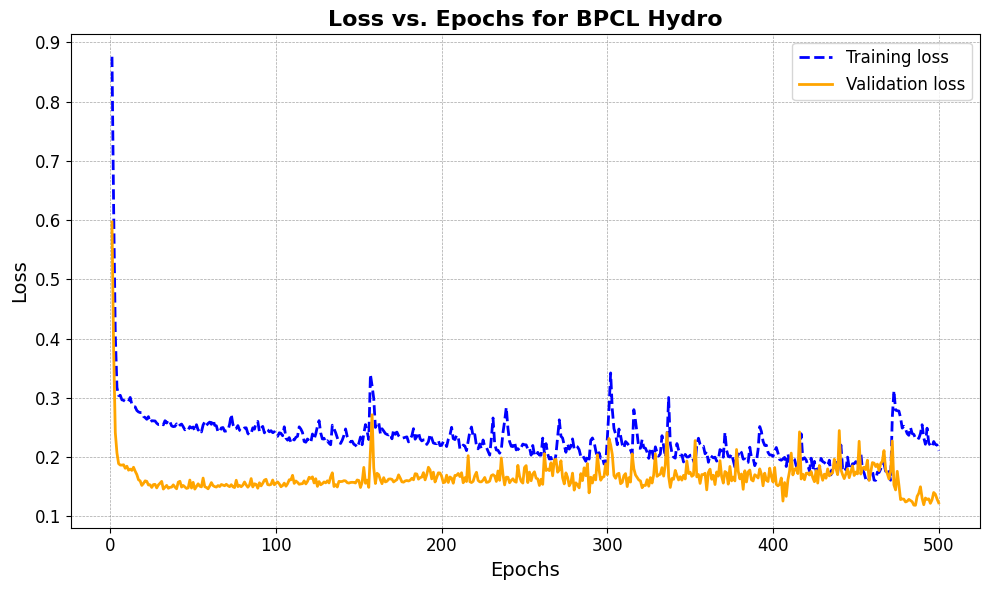

In [7]:
epochs = range(1, epochs+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label="Training loss", color="blue", linestyle="--", linewidth=2)
plt.plot(epochs, validation_loss, label="Validation loss", color="orange", linestyle="-", linewidth=2)

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Loss vs. Epochs for BPCL Hydro", fontsize=16, weight="bold")

plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()